# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [2]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal.

Answer: nvidia geforce gtx 1050 Ti with Q-max design

Question 2: Google the name of the graphics card, how many CUDA cores does it have?

Answer: 768 CUDA cores

Question 3: How much memory does the graphics card have?

Answer: 4 GB

Question 4: What is stored in the GPU memory while training a DNN ?

Answer: weights and all the information required for backpropagation (values after every layer) 

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

Answer: Intel i7-8565u, 4 cores 

Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.

Answer: 16384MB 

# Part 4: Load the data

Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.




In [2]:
from numpy import genfromtxt
import numpy as np

# Load data from file
# X = covariates, Y = labels

#X = np.genfromtxt('C:\\Users\\marty\\Desktop\\Mirai_dataset.csv', delimiter=',')
#Y = np.load('C:\\Users\\marty\\Desktop\\Mirai_labels.npy')

# Save data as numpy arrays, for faster loading in future calls to this cell
#np.save('Mirai_data.npy', X)
#np.save('Mirai_labels.npy', Y)

# Load data from numpy arrays, for faster loading
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates
#X = X[:,16:].shape


print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
    
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print("Frequency of unique labels:")
print(np.asarray((unique_elements, counts_elements)))

The covariates have size (764137, 116).
The labels have size (764137,).
Frequency of unique labels:
[[0.00000e+00 1.00000e+00]
 [1.21621e+05 6.42516e+05]]


# Part 5: How good is a naive classifier?

Question 7: Given the distribution of examples, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by random chance.

In [9]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()


# Print the number of NaNs (not a number) in the labels
print(sum(np.isnan(Y)))

# Print the number of NaNs in the covariates
print(sum(sum(np.isnan(X))))

0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [3]:
# Convert covariates to floats
X =X.astype(float)

# Convert labels to ints
Y = Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X, axis = 0)

# Divide each covariate (column) by its standard deviation
X = X / np.std(X, axis = 0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X, axis = 0))
print(np.std(X, axis = 0))

[-1.02064089e-17  2.85382954e-14 -9.20505107e-15 -1.06841609e-14
  5.06529540e-15 -1.37998931e-13  3.35034477e-15  6.16487545e-14
 -3.16897630e-14  2.74468582e-15 -7.37693318e-14  1.11702013e-13
  5.71930497e-15  4.89409286e-14  1.37481645e-13 -1.73225692e-15
  2.85382954e-14 -9.20505107e-15 -1.06841609e-14  5.06529540e-15
 -1.37998931e-13  3.35034477e-15  6.29496608e-14 -3.21702133e-14
 -3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)


In [4]:
# Your code
from sklearn.model_selection import train_test_split as tts
Xtrain,Xtemp, Ytrain, Ytemp = tts(X, Y , test_size = 0.3)


print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%



Xtrain has size (534895, 116).
Ytrain has size (534895,).
Xtemp has size (229242, 116).
Ytemp has size (229242,).


# Part 8: Number of examples per class

Question 8: Can we use the dataset as it is? Why not?

Lets randomly shuffle the data, to get some examples of each class in training data and in the remaining 30%. Use the function `shuffle` in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

In [5]:
from sklearn.utils import shuffle

# Randomly shuffle data, to get both classes in training and testing
X, Y = shuffle(X, Y)

# Divide the data into training and validation/test again
Xtrain,Xtemp, Ytrain, Ytemp = tts(X, Y , test_size = 0.3)

# Print the number of examples of each class, for the training data and the remaining 30%
print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))


Xtrain has size (534895, 116).
Ytrain has size (534895,).
Xtemp has size (229242, 116).
Ytemp has size (229242,).


#  Part 9: Split non-training data data into validation and test
Split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [6]:
from sklearn.model_selection import train_test_split

Xval ,Xtest, Yval, Ytest = tts(Xtemp, Ytemp , test_size = 0.5)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 116), (114621, 116), (114621,) and (114621,)


# Part 10: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False, d_rate=0.5):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    # Setup a sequential model
    model = Sequential()
    
    # Add layers to the model, using the input parameters of the build_DNN function
    model.add(Dense(n_nodes, activation = act_fun, input_shape=input_shape))
    if(use_bn):
        model.add(BatchNormalization())
    if(use_dropout):
        model.add(Dropout(d_rate))
    # Add first layer, requires input shape
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation= act_fun))
        if(use_bn):
            model.add(BatchNormalization())
        if(use_dropout):
            model.add(Dropout(d_rate))
    
    # Final layer
    model.add(Dense(1 ,activation = "sigmoid"))
    
    # Compile model
    model.compile(optimizer=opt, loss='binary_crossentropy',  metrics=['accuracy'])
    
    
    return model

(116,)

In [15]:
# Lets define a help function for plotting the training results

# IMPORTANT NOTE
# The history unfortunately behaves a bit randomly for every user
# If the plots for accuracy and loss look mixed, change the order of
# val_loss, val_acc, loss, acc
# until the plots look as they "should"

import matplotlib.pyplot as plt
def plot_results(history):
    val_loss, val_acc, loss, acc = history.history.values()

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 11: Train the DNN

Time to train the DNN, we start simple with 2 layers with 2 nodes each, learning rate 0.1.

### 2 layers, 20 nodes

In [75]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain[0,:].shape

# Build the model
model1 = build_DNN(input_shape,2,20)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=20000, epochs=100, validation_data = (Xval,Yval))

Epoch 1/100
27/27 [==============================] - 1s 29ms/step - loss: 0.5015 - accuracy: 0.8407 - val_loss: 0.4785 - val_accuracy: 0.8414
Epoch 2/100
27/27 [==============================] - 0s 12ms/step - loss: 0.4666 - accuracy: 0.8407 - val_loss: 0.4550 - val_accuracy: 0.8414
Epoch 3/100
27/27 [==============================] - 0s 11ms/step - loss: 0.4490 - accuracy: 0.8407 - val_loss: 0.4422 - val_accuracy: 0.8414
Epoch 4/100
27/27 [==============================] - 0s 11ms/step - loss: 0.4390 - accuracy: 0.8407 - val_loss: 0.4343 - val_accuracy: 0.8414
Epoch 5/100
27/27 [==============================] - 0s 12ms/step - loss: 0.4324 - accuracy: 0.8407 - val_loss: 0.4288 - val_accuracy: 0.8414
Epoch 6/100
27/27 [==============================] - 0s 11ms/step - loss: 0.4275 - accuracy: 0.8407 - val_loss: 0.4244 - val_accuracy: 0.8414
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 0.4235 - accuracy: 0.8407 - val_loss: 0.4207 - val_accuracy: 0.8414
Epoch 

In [76]:
# Evaluate the model on the test data
score  = model1.evaluate(Xtest, Ytest, batch_size = 8000)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

15/15 [==============================] - 0s 5ms/step - loss: 0.1991 - accuracy: 0.9101
Test loss: 0.1991
Test accuracy: 0.9101


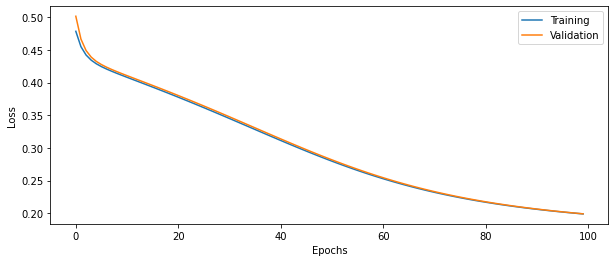

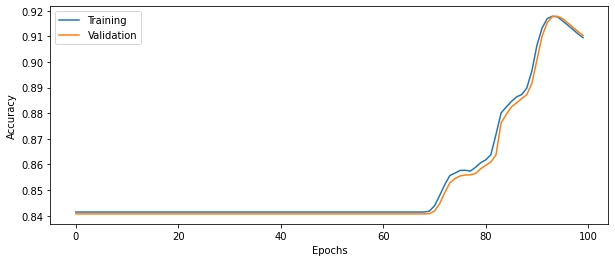

In [77]:
# Plot the history from the training run
plot_results(history1)

# Part 12: More questions

Question 9: What happens if you add several Dense layers without specifying the activation function?

it will be additional scaling(weight multiplication) so it kind of doesnt make sense as these weights are learnt. 

Question 10: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

kernel_initializer="glorot_uniform", Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
bias_initializer="zeros", bias will be 0 

# Part 13: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [9]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(Ytrain) ,y= Ytrain)

# Print the class weights
print(class_weights)
print(np.unique(Ytrain))

weight_labels = dict(enumerate(class_weights))
print(weight_labels)

[3.13430955 0.59490153]
[0 1]
{0: 3.134309554782079, 1: 0.5949015272507262}


### 2 layers, 20 nodes, class weights

In [108]:
# Setup some training parameters
batch_size = 10000
epochs = 10
input_shape = Xtrain[0,:].shape

# Build and train model
# Build the model
model2 = build_DNN(input_shape,2,20,learning_rate = 0.5)
model2.summary()

# Train the model, provide training data and validation data
history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data = (Xval,Yval), class_weight = weight_labels)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 20)                2340      
_________________________________________________________________
dense_80 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 21        
Total params: 2,781
Trainable params: 2,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
54/54 [==============================] - 1s 12ms/step - loss: 0.3465 - accuracy: 0.8558 - val_loss: 0.2500 - val_accuracy: 0.8969
Epoch 2/10
54/54 [==============================] - 0s 8ms/step - loss: 0.1932 - accuracy: 0.8993 - val_loss: 0.2332 - val_accuracy: 0.8984
Epoch 3/10
54/54 [==============================] - 0s 8ms/step - loss: 0.1766 - accuracy: 0.9016 - 

In [106]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size = 8000)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

15/15 [==============================] - 0s 5ms/step - loss: 0.0462 - accuracy: 0.9808
Test loss: 0.0462
Test accuracy: 0.9808


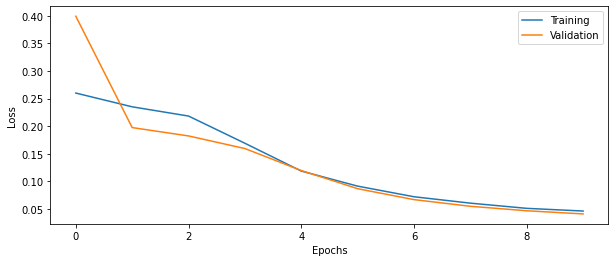

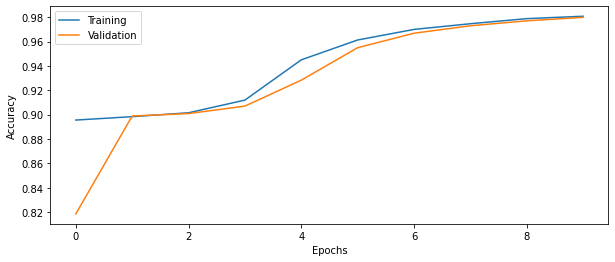

In [107]:
plot_results(history2)

# Part 14: More questions

Question 11: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Because we will tun out of memory. 

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

10-12% 455MB

Question 13: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

100 - 18s
1000 - 2s
10000 - 1s

Question 14: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

100-5349
1000-535
10000-54

Question 15: What limits how large the batch size can be?

max size is amount of data points, but also batch size is limited by memory size

Question 16: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

smaller batch size -> more updates so learning rate should be decreased

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 15: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 17: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

2,781 - 2 layer 20 nodes
3,621 - 4 layers 20 nodes


### 4 layers, 20 nodes, class weights

In [109]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X[0,:].shape

# Build and train model
model3 = build_DNN(input_shape,4,20,learning_rate = 0.1)
model3.summary()

# Train the model, provide training data and validation data
history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data = (Xval,Yval), class_weight = weight_labels)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 20)                2340      
_________________________________________________________________
dense_83 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_84 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_85 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 21        
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
54/54 [==============================] - 1s 12ms/step - loss: 0.7090 - accuracy: 0.4268 - val_loss: 0.6902

In [110]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size = 8000)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

15/15 [==============================] - 0s 5ms/step - loss: 0.2734 - accuracy: 0.8950
Test loss: 0.2734
Test accuracy: 0.8950


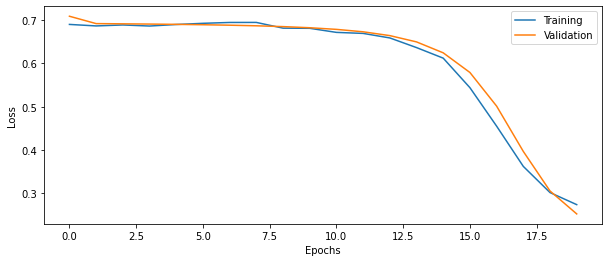

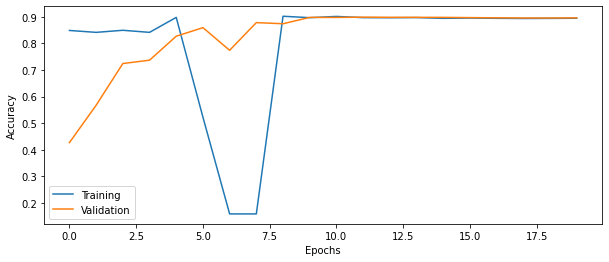

In [111]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [114]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0,:].shape

# Build and train model
model4 = build_DNN(input_shape,4,20,learning_rate = 0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, validation_data = (Xval,Yval),class_weight = weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 12ms/step - loss: 0.7091 - accuracy: 0.3418 - val_loss: 0.6968 - val_accuracy: 0.1586
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.5328 - val_loss: 0.6945 - val_accuracy: 0.1593
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.5716 - val_loss: 0.6869 - val_accuracy: 0.8415
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.7149 - val_loss: 0.6872 - val_accuracy: 0.8416
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.6566 - val_loss: 0.6876 - val_accuracy: 0.8429
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6902 - accuracy: 0.7067 - val_loss: 0.6875 - val_accuracy: 0.8791
Epoch 7/20
54/54 [==============================] - 0s 9ms/step - loss: 0.6894 - accuracy: 0.7911 - val_loss: 0.6875 - val_accuracy: 0.8978
Epoch 8/20
54/54 [=

In [116]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.2734 - accuracy: 0.8950
Test loss: 0.2734
Test accuracy: 0.8950


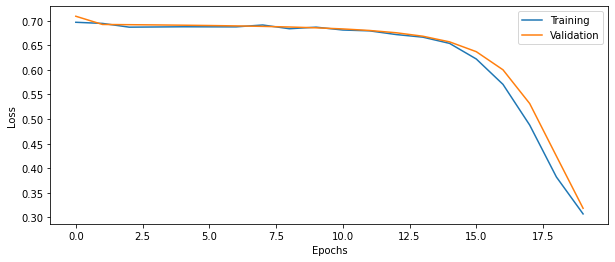

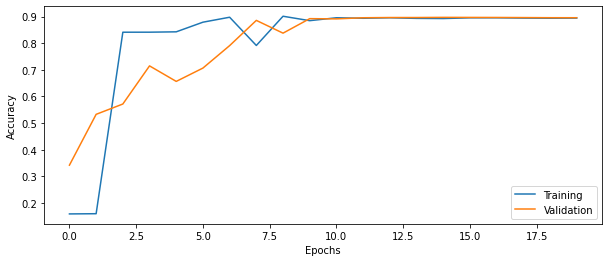

In [117]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [119]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0,:].shape

# Build and train model
model5 = build_DNN(input_shape,4,50,learning_rate = 0.1)

history5 = model5.fit(Xtrain,Ytrain, epochs=epochs, batch_size = batch_size, validation_data = (Xval,Yval), class_weight = weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 13ms/step - loss: 0.6945 - accuracy: 0.5880 - val_loss: 0.6971 - val_accuracy: 0.1586
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6917 - accuracy: 0.5159 - val_loss: 0.6872 - val_accuracy: 0.8416
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6902 - accuracy: 0.7557 - val_loss: 0.6896 - val_accuracy: 0.8927
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.7746 - val_loss: 0.6887 - val_accuracy: 0.8886
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6864 - accuracy: 0.8390 - val_loss: 0.6883 - val_accuracy: 0.8794
Epoch 6/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6834 - accuracy: 0.8676 - val_loss: 0.6833 - val_accuracy: 0.8912
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6789 - accuracy: 0.8932 - val_loss: 0.6746 - val_accuracy: 0.8973
Epoch 8/20
54

In [120]:
# Evaluate model on test data
score = model5.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 7s 2ms/step - loss: 0.2336 - accuracy: 0.8993
Test loss: 0.2336
Test accuracy: 0.8993


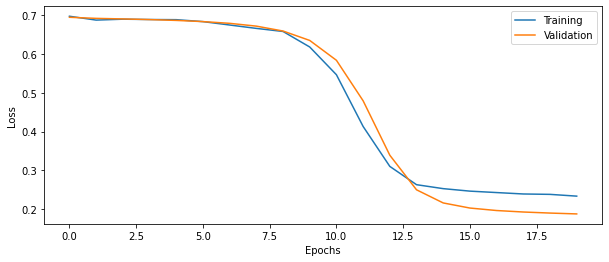

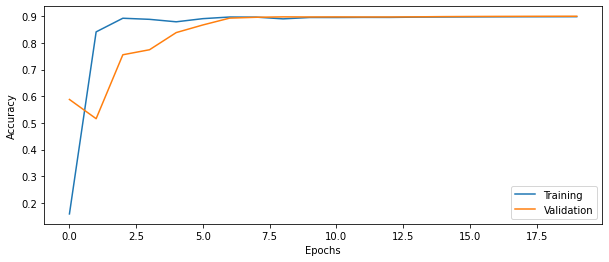

In [121]:
plot_results(history5)

# Part 16: Batch normalization

Now add batch normalization after each dense layer. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 18: Why is batch normalization important when training deep networks? avoids exploding\vanishing gradient 

### 2 layers, 20 nodes, class weights, batch normalization

In [126]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0,:].shape

# Build and train model
model6 = build_DNN(input_shape,4,50,learning_rate = 0.1,use_bn=True)

history6 = model6.fit(Xtrain,Ytrain, epochs = epochs, batch_size = batch_size, validation_data = (Xval,Yval), class_weight=weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 18ms/step - loss: 0.2407 - accuracy: 0.8988 - val_loss: 0.4214 - val_accuracy: 0.8414
Epoch 2/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1116 - accuracy: 0.9539 - val_loss: 0.4166 - val_accuracy: 0.8414
Epoch 3/20
54/54 [==============================] - 1s 15ms/step - loss: 0.0766 - accuracy: 0.9680 - val_loss: 0.3671 - val_accuracy: 0.8414
Epoch 4/20
54/54 [==============================] - 1s 14ms/step - loss: 0.0594 - accuracy: 0.9743 - val_loss: 0.2894 - val_accuracy: 0.8414
Epoch 5/20
54/54 [==============================] - 1s 14ms/step - loss: 0.0482 - accuracy: 0.9791 - val_loss: 0.2065 - val_accuracy: 0.8630
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.0412 - accuracy: 0.9822 - val_loss: 0.1368 - val_accuracy: 0.9593
Epoch 7/20
54/54 [==============================] - 1s 14ms/step - loss: 0.0362 - accuracy: 0.9841 - val_loss: 0.0797 - val_accuracy: 0.9787
Epoch 8/20
54

In [129]:
# Evaluate model on test data
score = model6.evaluate(Xtest,Ytest,batch_size=Xtest[:,0].shape[0])

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - accuracy: 0.9919
Test loss: 0.0219
Test accuracy: 0.9919


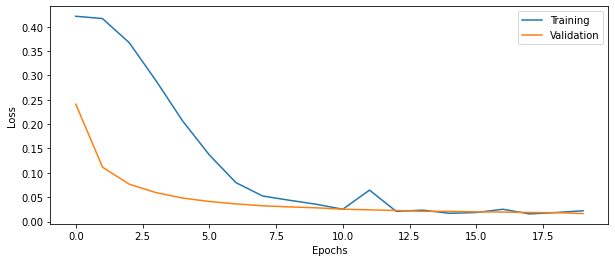

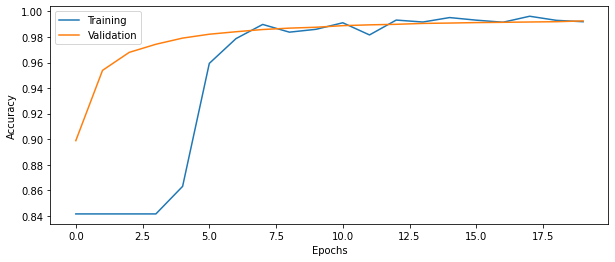

In [131]:
plot_results(history6)

# Part 17: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [29]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0].shape

# Build and train model
model7 = build_DNN(input_shape,2,20,learning_rate = 0.1,use_bn=False, act_fun = "relu")

history7 = model7.fit(Xtrain,Ytrain, epochs = epochs, batch_size = batch_size, validation_data = (Xval,Yval), class_weight=weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2695 - accuracy: 0.8963 - val_loss: 0.2074 - val_accuracy: 0.9035
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1302 - accuracy: 0.9227 - val_loss: 0.1237 - val_accuracy: 0.9457
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0868 - accuracy: 0.9544 - val_loss: 0.0893 - val_accuracy: 0.9630
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0641 - accuracy: 0.9671 - val_loss: 0.0666 - val_accuracy: 0.9723
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0519 - accuracy: 0.9734 - val_loss: 0.0638 - val_accuracy: 0.9736
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9773 - val_loss: 0.0522 - val_accuracy: 0.9781
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.9798 - val_loss: 0.0449 - val_accuracy: 0.9811
Epoch 8/20
54/54 [=

In [30]:
# Evaluate model on test data
score = model7.evaluate(Xtest,Ytest,batch_size=Xtest[:,0].shape[0])

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

1/1 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9921
Test loss: 0.0209
Test accuracy: 0.9921


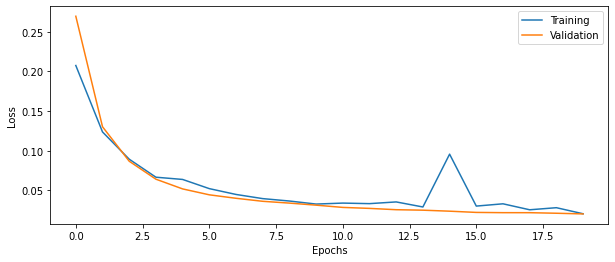

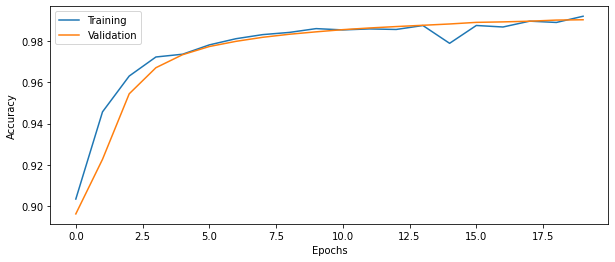

In [31]:
plot_results(history7)

# Part 18: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [42]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0].shape

# Build and train model
model8 = build_DNN(input_shape,2,20,learning_rate = 0.1,use_bn=False, act_fun = "sigmoid", optimizer = "adam")

history8 = model8.fit(Xtrain,Ytrain, epochs = epochs, batch_size = batch_size, validation_data = (Xval,Yval), class_weight=weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1886 - accuracy: 0.8974 - val_loss: 0.1028 - val_accuracy: 0.9635
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.9732 - val_loss: 0.0352 - val_accuracy: 0.9882
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.0306 - val_accuracy: 0.9902
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0277 - accuracy: 0.9892 - val_loss: 0.0230 - val_accuracy: 0.9921
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0274 - accuracy: 0.9889 - val_loss: 0.0246 - val_accuracy: 0.9919
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0270 - accuracy: 0.9891 - val_loss: 0.0238 - val_accuracy: 0.9919
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.9918 - val_loss: 0.0287 - val_accuracy: 0.9889
Epoch 8/20
54/54 [=

In [43]:
# Evaluate model on test data
score = model8.evaluate(Xtest,Ytest,batch_size=Xtest[:,0].shape[0])

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

1/1 [==============================] - 0s 0s/step - loss: 0.0095 - accuracy: 0.9965
Test loss: 0.0095
Test accuracy: 0.9965


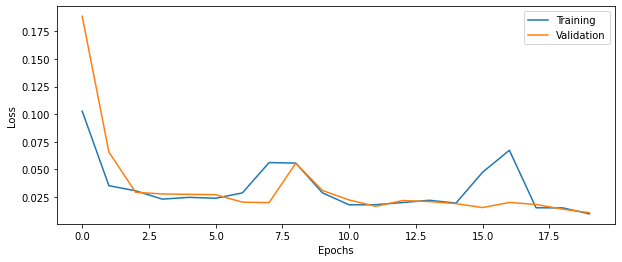

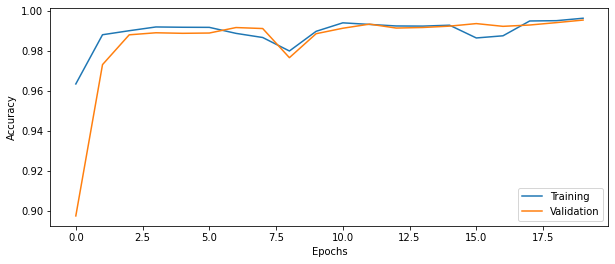

In [44]:
plot_results(history8)

# Part 19: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer), with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/layers/core/ for how the Dropout layer works.

---

Question 19: How does the validation accuracy change when adding dropout?

Question 20: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [47]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain[0].shape

# Build and train model
model9 = build_DNN(input_shape,2,20,learning_rate = 0.1,use_bn=False, act_fun = "sigmoid", optimizer = "sgd" ,use_dropout = True)

history9 = model9.fit(Xtrain,Ytrain, epochs = epochs, batch_size = batch_size, validation_data = (Xval,Yval), class_weight=weight_labels)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2586 - accuracy: 0.8695 - val_loss: 0.2507 - val_accuracy: 0.8970
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1920 - accuracy: 0.9034 - val_loss: 0.1964 - val_accuracy: 0.9144
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1222 - accuracy: 0.9388 - val_loss: 0.0648 - val_accuracy: 0.9779
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0764 - accuracy: 0.9657 - val_loss: 0.0538 - val_accuracy: 0.9799
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0602 - accuracy: 0.9738 - val_loss: 0.0349 - val_accuracy: 0.9849
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.0555 - accuracy: 0.9748 - val_loss: 0.0368 - val_accuracy: 0.9839
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9768 - val_loss: 0.0252 - val_accuracy: 0.9876
Epoch 8/20
54/54 [=

In [48]:
# Evaluate model on test data
score = model9.evaluate(Xtest,Ytest,batch_size=Xtest[:,0].shape[0])

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

1/1 [==============================] - 0s 0s/step - loss: 0.0241 - accuracy: 0.9888
Test loss: 0.0241
Test accuracy: 0.9888


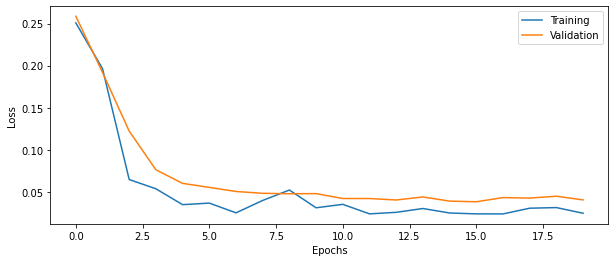

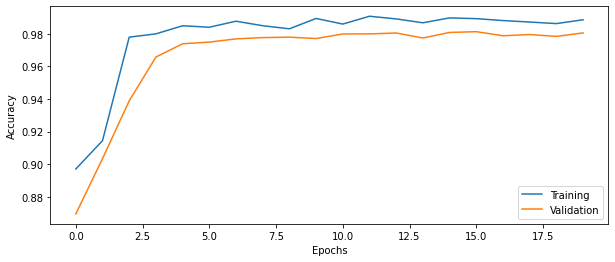

In [49]:
plot_results(history9)

# Part 20: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?
18.3 s 

Question 21: How high classification accuracy can you achieve for the test data? What is your best configuration?
Test accuracy: 0.9927
batch_size = 5000
epochs = 80
RELU 
ADAM
learning rate = 0.1
dropout 0.5
12 layers of 15 neurons 


In [23]:
# Find your best configuration for the DNN

batch_size = 5000
epochs = 80
input_shape = Xtrain[0].shape




model10 = build_DNN(input_shape,12,15,learning_rate = 0.1, use_bn=True, act_fun = "relu", optimizer = "adam" ,use_dropout = True)
history10 = model10.fit(Xtrain,Ytrain, epochs = epochs, batch_size = batch_size,verbose = 2 , validation_data = (Xval,Yval), class_weight=weight_labels)

score = model10.evaluate(Xtest,Ytest,batch_size=Xtest[:,0].shape[0])
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


Epoch 1/80
107/107 - 2s - loss: 0.5908 - accuracy: 0.7663 - val_loss: 110.0683 - val_accuracy: 0.1583
Epoch 2/80
107/107 - 2s - loss: 0.2877 - accuracy: 0.9470 - val_loss: 0.6707 - val_accuracy: 0.9767
Epoch 3/80
107/107 - 2s - loss: 0.2106 - accuracy: 0.9632 - val_loss: 0.0543 - val_accuracy: 0.9893
Epoch 4/80
107/107 - 2s - loss: 0.1579 - accuracy: 0.9717 - val_loss: 0.0428 - val_accuracy: 0.9875
Epoch 5/80
107/107 - 2s - loss: 0.1556 - accuracy: 0.9715 - val_loss: 0.1925 - val_accuracy: 0.8573
Epoch 6/80
107/107 - 2s - loss: 0.1430 - accuracy: 0.9712 - val_loss: 0.0415 - val_accuracy: 0.9846
Epoch 7/80
107/107 - 2s - loss: 0.1232 - accuracy: 0.9752 - val_loss: 0.1424 - val_accuracy: 0.9801
Epoch 8/80
107/107 - 2s - loss: 0.1656 - accuracy: 0.9567 - val_loss: 0.0923 - val_accuracy: 0.9831
Epoch 9/80
107/107 - 2s - loss: 0.1233 - accuracy: 0.9735 - val_loss: 0.0487 - val_accuracy: 0.9826
Epoch 10/80
107/107 - 2s - loss: 0.1556 - accuracy: 0.9663 - val_loss: 0.0474 - val_accuracy: 0.98

In [17]:
Xtrain.shape

(534895, 116)

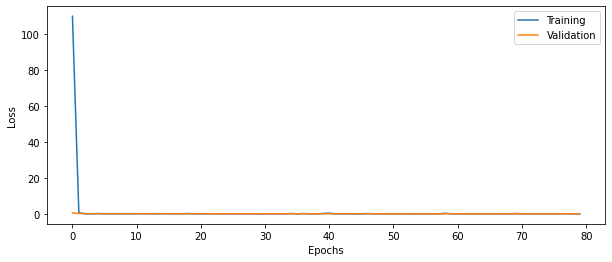

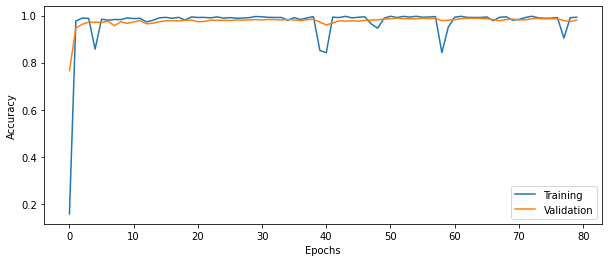

In [24]:
# Evaluate DNN on test data
plot_results(history10)

# Part 21: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 22: What is the mean and the standard deviation of the test accuracy?

In [ ]:
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [ ]:
# Your best training parameters


# Build and train model
model11 = 

history11 = 

In [ ]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = 
                       
print('Test accuracy: %.4f' % score[1])

In [ ]:
# Run the testing 100 times, and save the accuracies in an array

    
# Calculate and print mean and std of accuracies



# Part 22: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 23: What is the mean and the standard deviation of the test accuracy?

Question 24: What is the main advantage of dropout compared to CV for estimating test uncertainty?

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation

# Loop over cross validation folds
    
    # Calculate class weights for current split
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    
    # Fit the model with training set and class weights for this fold
    
    # Evaluate the model using the test set for this fold
    
    # Save the test accuracy in an array

# Calculate and print mean and std of accuracies



# Part 23: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 25: How would you change the DNN in order to use it for regression instead?

## Report

Send in this jupyter notebook, with answers to all questions.